In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Disable scientific notation on axes
plt.rcParams["axes.formatter.limits"] = (-99, 99)
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Read Seoul bike sharing information, replacing non UTF-8 chars with �
df = pd.read_csv('SeoulBikeData.csv', encoding_errors='replace')
print(len(df))

# Remove the � from any column name
for col_name in list(df):
    if '�' in col_name:
        df.rename(columns={col_name : col_name.replace('�','')}, inplace=True)

# Convert holiday to binary 1 for Yes, 0 for anythng else
# df['Holiday'] = np.where(df['Holiday'] == 'Holiday',1,0)

# Remove lines where rentals not available
df = df[df['Functioning Day'] == "Yes"]
df['dt_index'] = df['Date'] + ' ' + df['Hour'].astype(str)
df['dt_index'] = pd.to_datetime(df['dt_index'], format='%d/%m/%Y %H')

df_copy = df.copy()
####### Chris ##########
# remove unwanted columns, having no contribution in model prediction
df = df.drop(['Date','dt_index'],axis=1)

# df_copy = df.copy()

####### Chris ##########
# perform ohe hot encoding to convert categorical columns to numerical
df = pd.get_dummies(df)

# Use the last 30% for testing
train_test_split = int(np.floor(len(df) * 0.7))
df_train = df.iloc[:train_test_split].copy()
df_test = df.iloc[train_test_split:].copy()

# Show data by season
grouped = df_copy[['Seasons', 'Rented Bike Count', 'Temperature(C)']].groupby('Seasons').mean()
print(grouped)

# Show correlation between "Rented Bike Count" and the other numeric features
print(df_train.corr(method='pearson', numeric_only=True).iloc[0])

8760
         Rented Bike Count  Temperature(C)
Seasons                                   
Autumn          924.110480       13.821683
Spring          746.254167       13.021759
Summer         1034.073370       26.582790
Winter          225.541204       -2.540463
Rented Bike Count           1.000000
Hour                        0.384390
Temperature(C)              0.623219
Humidity(%)                -0.143500
Wind speed (m/s)            0.133041
Visibility (10m)            0.143130
Dew point temperature(C)    0.473146
Solar Radiation (MJ/m2)     0.317750
Rainfall(mm)               -0.112400
Snowfall (cm)              -0.162114
Seasons_Autumn                   NaN
Seasons_Spring              0.115846
Seasons_Summer              0.418837
Seasons_Winter             -0.502582
Holiday_Holiday            -0.099087
Holiday_No Holiday          0.099087
Functioning Day_Yes              NaN
Name: Rented Bike Count, dtype: float64


In [3]:
list(df_train)

['Rented Bike Count',
 'Hour',
 'Temperature(C)',
 'Humidity(%)',
 'Wind speed (m/s)',
 'Visibility (10m)',
 'Dew point temperature(C)',
 'Solar Radiation (MJ/m2)',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Seasons_Autumn',
 'Seasons_Spring',
 'Seasons_Summer',
 'Seasons_Winter',
 'Holiday_Holiday',
 'Holiday_No Holiday',
 'Functioning Day_Yes']

In [4]:
####### Chris ##########
# dataframe to store results
result = pd.DataFrame([],columns=['Model','MSE'])

In [5]:
y_feature_name = 'Rented Bike Count'

# X_feature_list = ['Temperature(C)']

# Uncomment to set X and Y to the same thing to verify model working
# Model should have MSE of 0 and R2 score of 1

# ####### Chris ##########
# get features except target column i.e y_feature_name

X_feature_list = [
 'Holiday_No Holiday',
 'Seasons_Spring',
 'Visibility (10m)',
 'Functioning Day_Yes',
 'Seasons_Summer',
 'Seasons_Autumn',
 'Humidity(%)',
 'Dew point temperature(C)',
 'Hour',
 'Rainfall(mm)',
 'Snowfall (cm)',
 'Holiday_Holiday',
 'Seasons_Winter',
 'Temperature(C)',
 'Wind speed (m/s)',
 'Solar Radiation (MJ/m2)']

# X_feature_list = list(set(list(df_train))- set(y_feature_name))

# https://scikit-learn.org/stable/auto_examples/linear_model/plot_ols.html
X_train = np.array(df_train[X_feature_list])
y_train = np.array(df_train[y_feature_name])
X_test = np.array(df_test[X_feature_list])
y_test = np.array(df_test[y_feature_name])

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
mse = mean_squared_error(y_test, y_pred)
# The mean squared error
print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.5f" % r2_score(y_test, y_pred))

####### Chris ##########
# store result to result dataframe
result.loc[len(result)] = ['LinearRegression',mse]

# X_feature_list.append('y_test')
# X_feature_list.append('y_predict')
# y_results = pd.DataFrame(np.column_stack((X_test, y_test, y_pred)), columns=X_feature_list)
# print(np.shape(y_results))
# print(y_results.iloc[-5:,:])

# num_points = -20
# # Plot outputs
# plt.scatter(df_X_test[num_points:], df_y_test[num_points:], color="black")
# plt.plot(df_X_test[num_points:], df_y_test[num_points:], color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())

# plt.show()

#exploratory data anlysis
# Is there a strong correlation between bike rental count by season, temperature, humidity, rainfall, snowfall, etc.
# Metrics to engineer, revenue from bike rentals (using an estimate)
# Question to understand, if Rain, Temperature, Hunidity etc. increase what increase in bike rentals/revenue could we forecast?
# What if those values decreased? What decrease in revenue/bike rentals could we forecast?

Coefficients: 
 [ 4.49628357e+01  5.93971511e+01  3.53487945e-02  2.91322522e-13
  9.56907303e+01 -3.55271368e-14 -8.52389585e+00  7.13809681e+00
  2.49937786e+01 -5.97390327e+01  5.43938549e+01 -4.49628357e+01
 -1.55087881e+02  2.02293767e+01  2.60672580e+01 -6.01328332e+01]
Mean squared error: 247239.20026
Coefficient of determination: 0.34222


In [6]:
####### Chris ##########
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

In [7]:
####### Chris ##########
# apply RandomForestRegressor model
reg = RandomForestRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.3f" % mse)
result.loc[len(result)] = ['RandomForestRegressor',mse]

Mean squared error: 129619.759


In [8]:
####### Chris ##########
# apply DecisionTreeRegressor model
reg = DecisionTreeRegressor()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean squared error: %.3f" % mse)
result.loc[len(result)] = ['DecisionTreeRegressor',mse]

Mean squared error: 211949.501


In [9]:
result

,Model,MSE
0,LinearRegression,247239.200261
1,RandomForestRegressor,129619.759342
2,DecisionTreeRegressor,211949.500787


# EDA

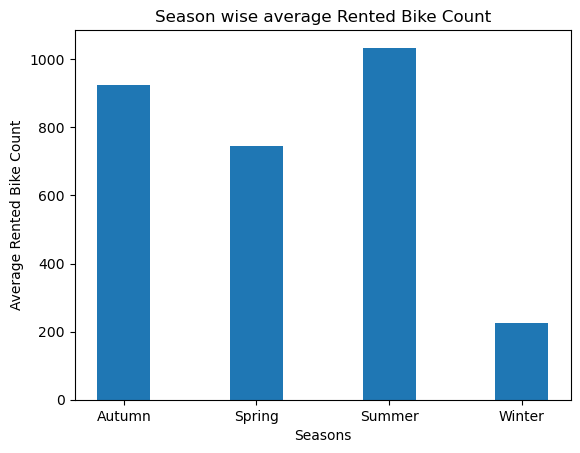

In [10]:
# Season wise average Rented Bike Count
a = df_copy[['Rented Bike Count','Seasons']].groupby('Seasons').mean()
plt.bar(a.index,list(a['Rented Bike Count']),width = 0.4)
plt.xlabel('Seasons')
plt.ylabel('Average Rented Bike Count')
plt.title('Season wise average Rented Bike Count')
plt.show()

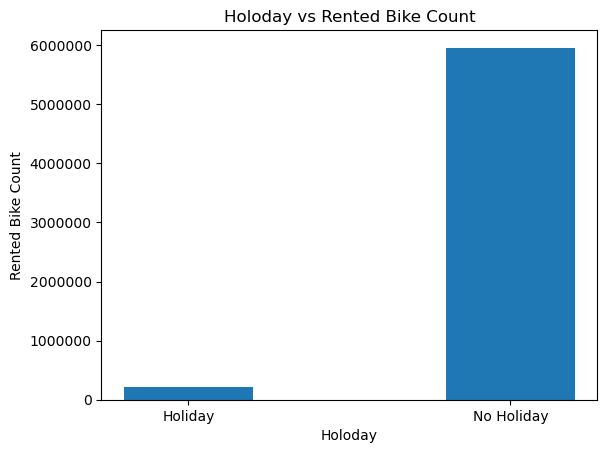

In [11]:
# Holoday vs Rented Bike Count
a = df_copy[['Rented Bike Count','Holiday']].groupby('Holiday').sum()
plt.bar(a.index,list(a['Rented Bike Count']),width = 0.4)
plt.xlabel('Holoday')
plt.ylabel('Rented Bike Count')
plt.title('Holoday vs Rented Bike Count')
plt.show()

In [12]:
# convert Date to datetime format
df_copy['Date'] = pd.to_datetime(df_copy['Date'],format='mixed')

In [13]:
# create day,month,year column
df_copy['month'] = df_copy['Date'].dt.month
df_copy['year'] = df_copy['Date'].dt.year
df_copy['day'] = df_copy['Date'].dt.day

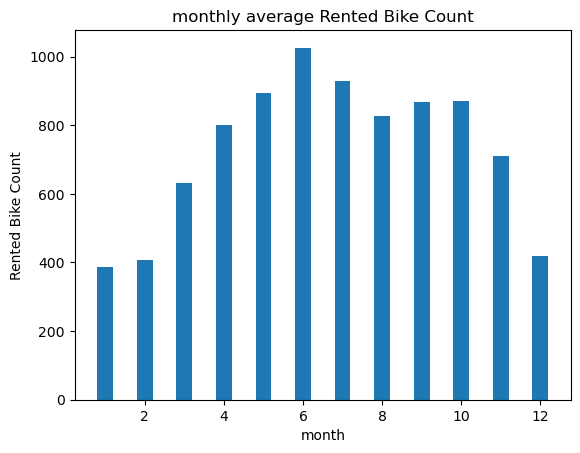

In [14]:
# monthly average Rented Bike Count
a = df_copy[['Rented Bike Count','month']].groupby('month').mean()
plt.bar(a.index,list(a['Rented Bike Count']),width = 0.4)
plt.xlabel('month')
plt.ylabel('Rented Bike Count')
plt.title('monthly average Rented Bike Count')
plt.show()

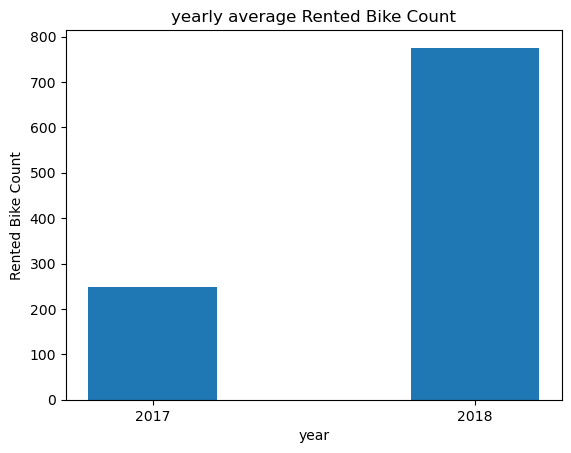

In [15]:
# Yearly average Rented Bike Count
a = df_copy[['Rented Bike Count','year']].groupby('year').mean()
plt.bar(a.index,list(a['Rented Bike Count']),width = 0.4)
plt.xticks(a.index, ['2017','2018'])
plt.xlabel('year')
plt.ylabel('Rented Bike Count')
plt.title('yearly average Rented Bike Count')
plt.show()

In [16]:
# get actual data year wise
df_copy['year'].value_counts()

year
2018    7721
2017     744
Name: count, dtype: int64

In [17]:
# get data for Holiday wise
df_copy['Holiday'].value_counts()

Holiday
No Holiday    8057
Holiday        408
Name: count, dtype: int64

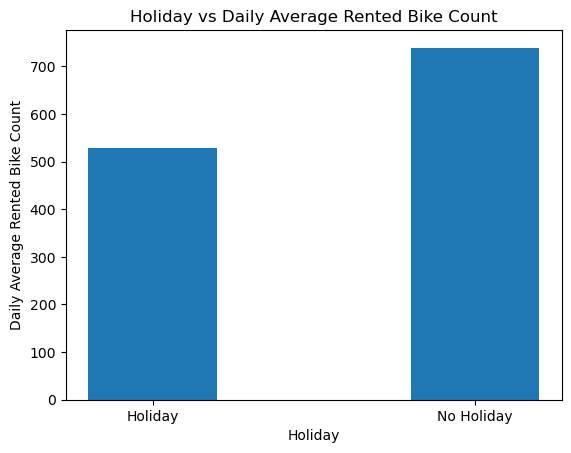

In [18]:
# Daily Average Rented Bike Count
a = df_copy[['Rented Bike Count','Holiday']].groupby('Holiday').mean()
plt.bar(a.index,list(a['Rented Bike Count']),width = 0.4)

plt.xlabel('Holiday')
plt.ylabel('Daily Average Rented Bike Count')
plt.title('Holiday vs Daily Average Rented Bike Count')

plt.show()

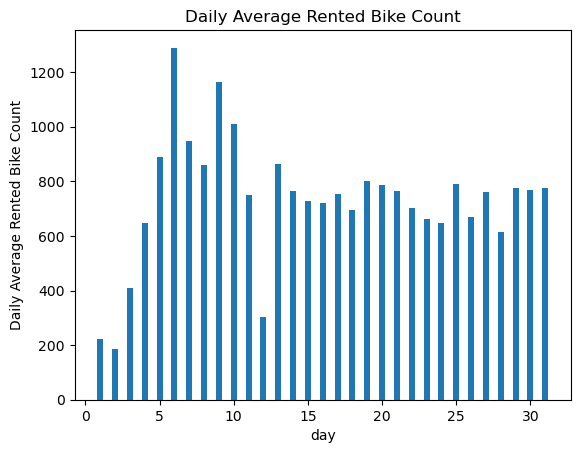

In [19]:
# Daily Average Rented Bike Count
a = df_copy[['Rented Bike Count','day']].groupby('day').mean()
plt.bar(a.index,list(a['Rented Bike Count']),width = 0.4)

plt.xlabel('day')
plt.ylabel('Daily Average Rented Bike Count')
plt.title('Daily Average Rented Bike Count')

plt.show()

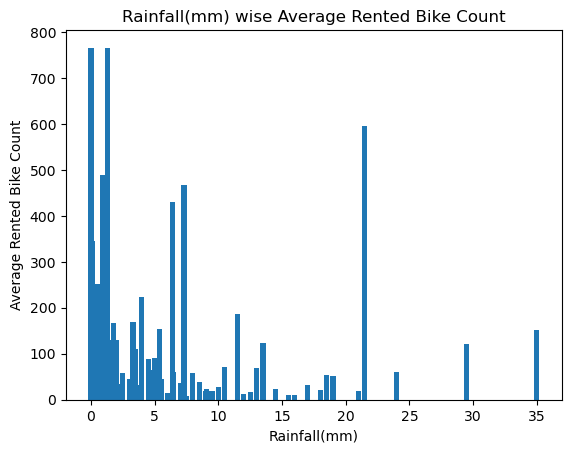

In [20]:
# Rainfall(mm) wise Average Rented Bike Count
a = df_copy[['Rented Bike Count','Rainfall(mm)']].groupby('Rainfall(mm)').mean()
plt.bar(a.index,list(a['Rented Bike Count']),width = .4)

plt.xlabel('Rainfall(mm)')
plt.ylabel('Average Rented Bike Count')
plt.title('Rainfall(mm) wise Average Rented Bike Count')

plt.show()

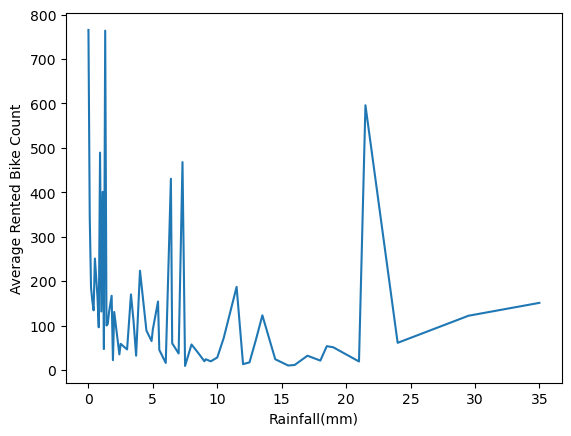

In [21]:
# Rainfall vs Average Rented Bike Count line plot
plt.plot(a.index,a['Rented Bike Count'])

plt.xlabel('Rainfall(mm)')
plt.ylabel('Average Rented Bike Count')
plt.show()

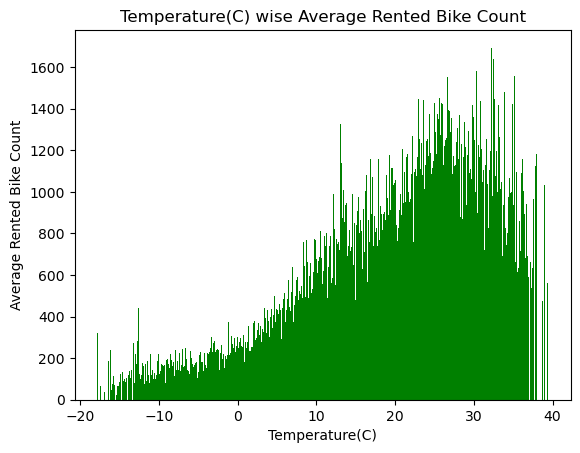

In [22]:
# Rainfall(mm) wise Average Rented Bike Count
a = df_copy[['Rented Bike Count','Temperature(C)']].groupby('Temperature(C)').mean()
plt.bar(a.index,list(a['Rented Bike Count']),width = .1,color='g')

plt.xlabel('Temperature(C)')
plt.ylabel('Average Rented Bike Count')
plt.title('Temperature(C) wise Average Rented Bike Count')

plt.show()